# Предсказание оттока клиентов в фитнес-центре

Мы работаем в сети фитнес-центров «Культурист-датасаентист», которая разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.  
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.


# Цель проекта.

Провести анализ данных клиентской базы сети фитнес-центров, спрогнозировать вероятность оттока клиентов, произвести кластерзацию и предложить меры по снижению их оттока. 


# Задачи проекта.

Во время исследования необходимо решить следующие задачи:

1. Изучить исходные данные и провести их предобработку.
2. Провести исследовательский анализ данных (EDA).
3. Построить модель прогнозирования оттока клиентов и оценить ее метрики.
4. Произвести кластеризацию клиентов и спрогнозировать отток кластеров.
5. Сформулировать выводы и разработать рекомендации по повышению качества работы с клиентами.


# Описание данных.  

<div style="border:solid black 1px; padding: 20px">   
 
Имеется датафрейм со следующими данными:
    
Структура *gym_churn.csv*: 
        
Данные клиента за предыдущий до проверки факта оттока месяц:  
    
•	`gender` — пол;  
•	`Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
•	`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
•	`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
•	`Phone` — наличие контактного телефона;  
•	`Age` — возраст;  
•	`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).  
    
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
    
•	`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
•	`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
•	`Group_visits` — факт посещения групповых занятий;  
•	`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
•	`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
•	`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
•	`Churn` — факт оттока в текущем месяце.  

## Импортируем библиотеки и изучим данные

In [1]:
import itertools
import warnings
warnings.filterwarnings('ignore') #убираем вывод предупреждений

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
path = 'C:\\Users\\User\\Documents\\Python Scripts\\Проект 12\\'
try:
    df = pd.read_csv(path + 'gym_churn.csv')
except:
    print('Loading Error')

In [3]:
NORM = '\033[0m'  # все атрибуты по умолчанию
BOLD = '\033[1m'  # жирный шрифт (интенсивный цвет)

#Напишем функцию для вывода основной информации о ДФ.
df_list = [df]
def full_info(df_list):
    for df in df_list:
        if len(df.index) > 10:
            print(BOLD+'\n Случайная выборка 10 строк датафрейма:')
            display (df.sample(n=10, random_state=10))
        else:
            print(BOLD+'\n Первые 10 строк датафрейма:')
            display (df.head(10))
        print(BOLD+'\n Типы данных и общая информация: \n'+NORM)
        display(df.info())
        print(BOLD+' Наличие дубликатов: '+NORM, df.duplicated().sum())
        print(BOLD+'\n Наличие пропусков: \n'+NORM)
        display(df.isna().sum())
        print(BOLD+'\n Статистики количественных переменных :')
        display(df.describe())
    return

In [4]:
full_info(df_list)


 Случайная выборка 10 строк датафрейма:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
2177,1,1,1,1,1,12,0,25,9.054828,9.0,3,1.060014,1.004836,0
2382,0,1,1,0,1,1,0,21,228.461172,1.0,0,1.258922,0.314098,1
1715,0,1,0,0,1,6,1,28,145.586247,6.0,3,3.541247,3.526442,0
2303,1,0,0,0,1,1,0,30,257.432578,1.0,1,2.153766,1.513633,1
822,0,1,1,1,1,1,1,29,460.904008,1.0,10,3.157764,3.154869,0
1055,1,1,0,0,1,1,0,29,220.185520,1.0,3,0.716460,0.578145,0
2429,0,1,1,0,1,12,1,34,163.482285,12.0,6,3.266246,3.207537,0
237,0,1,0,0,1,6,1,27,196.685461,6.0,1,1.069102,0.992996,0
908,0,1,1,0,1,1,0,28,144.838780,1.0,3,1.937354,1.835332,0
1243,0,1,0,0,1,1,0,38,53.540153,1.0,5,2.821721,2.786275,0



 Типы данных и общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_

None

 Наличие дубликатов:  0

 Наличие пропусков: 



gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


 Статистики количественных переменных :


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Вывод

<div style="border:solid green 2px; padding: 20px">
Данные изучены и готовы для дальнейшего исследования, т.к. ДФ в идеальном состоянии - дубликаты и пропуска отсутствуют, типы данных верные. Учитывая квартили и логически анализируя жизненный опыт, можно сказать, что аномальных значений в ДФ не наблюдается, все они выглядят правдоподобно и естественно. Для удобства заменены только названия столбцов.
    
Если сравнить средние значения с медианами с учетом стандартного отклонения, можно увидеть, что клиенты по полу, партнерской программе, факту посещения групповых программ, возрасту и количеству посещений в неделю за все время распределены равномерно, по локации большая часть живет рядом с ФЦ, не пользовалась услугой "приведи друга", предоставила контактный номер, оформила краткосрочный договор на услуги (и соответственно с небольшим сроком до окончания его действия), суммы покупок доп.услуг и количество посещений в неделю последний месяцскошены влево к небольшим значениям.

## Исследовательский анализ данных (EDA)

### Оценка средних значений признаков в двух группах

Для начала посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [6]:
groups = df.pivot_table(index='churn', aggfunc='mean').T
groups['ratio'] = groups[0] / groups[1]
groups.sort_values(by='ratio', ascending=False)

churn,0,1,ratio
lifetime,4.711807,0.990575,4.756638
contract_period,5.747193,1.728558,3.324848
month_to_end_contract,5.283089,1.662582,3.177641
avg_class_frequency_current_month,2.027882,1.044546,1.941401
promo_friends,0.353522,0.183789,1.923520
group_visits,0.464103,0.268615,1.727768
partner,0.534195,0.355325,1.503398
avg_additional_charges_total,158.445715,115.082899,1.376796
avg_class_frequency_total,2.024876,1.474995,1.372802
near_location,0.873086,0.768143,1.136619


По средним значениям видна большая лояльность тех клиентов, кто не ушел, и меньшая тех, кто уже ушел, а именно:
- в 5 раз больше срок пользования услугами ФЦ (4.7 месяцев против 1)
- в 3 раза выше срок договора (5.7 месяцев против 1.7) и срок до окончания действия договора (5,3 месяца против 1.6) 
- в два раза больше посещений за последний месяц (2 против 1) и в полтора раза за весь период (2 против 1.5)
- в два и полтора раза соответственно выше факт скидочных программ за приведенного друга и за компанию-партнера (35% и 53% против 18% и 36% соответственно)
- в полтора раза больше средние покупки в фитнес-центре (159 против 115) и количество клиентов, посещающих групповые занятия (46% против 27%).  
Посмотрим на визуальную разницу между группами клиентов.

### Визуализация значений двух групп гистограммами и распределением признаков

In [7]:
#Напишем функцию с базовым набором параметров для построения гистограмм.
def hist_func(df, y_minimum, y_maximum, ylabel):
    """
    Функция для построения гистрограмм по заданным признакам
    
    df - датафрейм
    y_minimum, y_maximum - лимиты оси y
    ylabel - подпись оси y
    """
    for i, col in enumerate(df.drop('churn', axis = 1).columns):
        plt.figure(figsize=(10, 5))
        plt.hist(x=[df.query('churn == 0')[col], df.query('churn == 1')[col]],
                 stacked=False, bins = 10, density=True)
        plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
        plt.title('Гистограмма для признака {}'.format(col), fontsize=15)
        plt.ylabel(ylabel, fontsize=15)
        plt.ylim([y_minimum, y_maximum])
        plt.yticks(size = 13)
        plt.xticks(size = 13)
        plt.show()

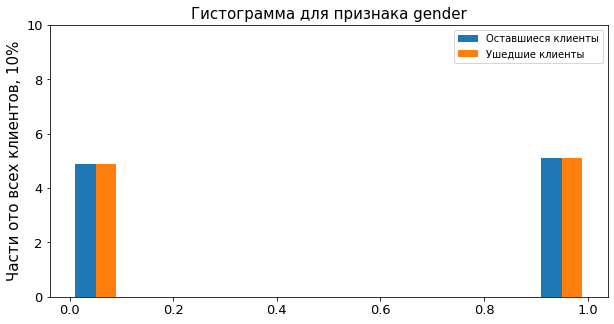

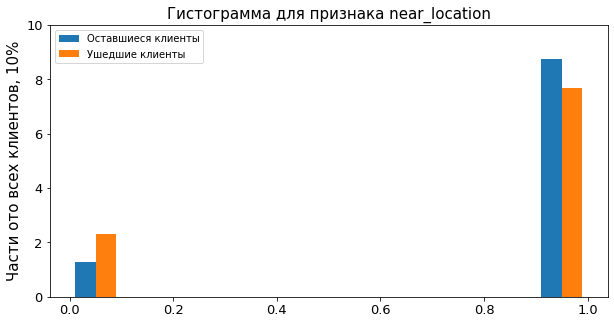

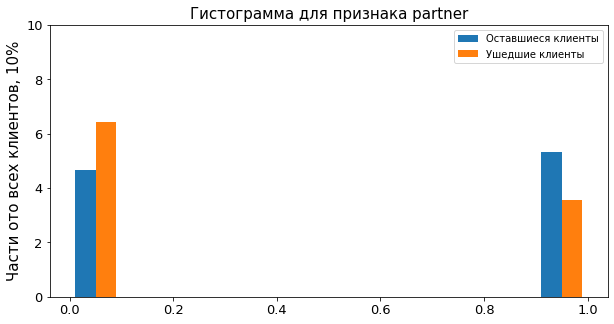

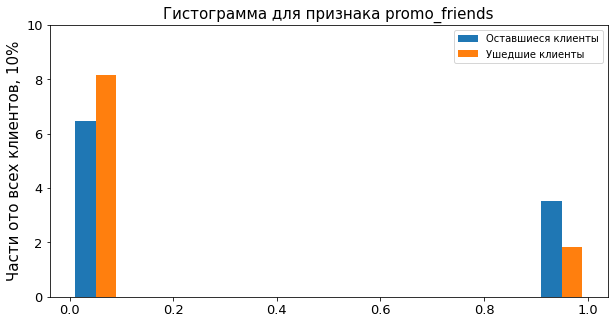

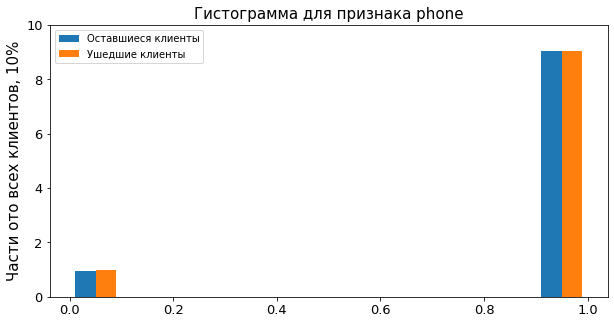

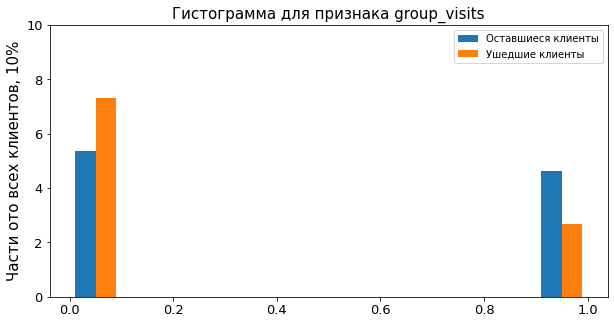

In [8]:
#Построим гистограммы для булевых значений.
df_bool = df[['gender', 'near_location', 'partner', 'promo_friends',
              'phone', 'group_visits', 'churn']]
hist_func(df_bool, 0, 10, 'Части ото всех клиентов, 10%')

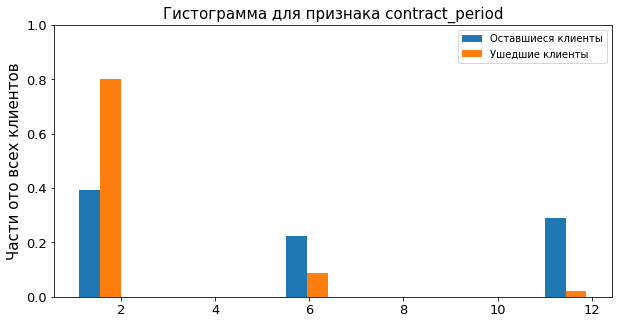

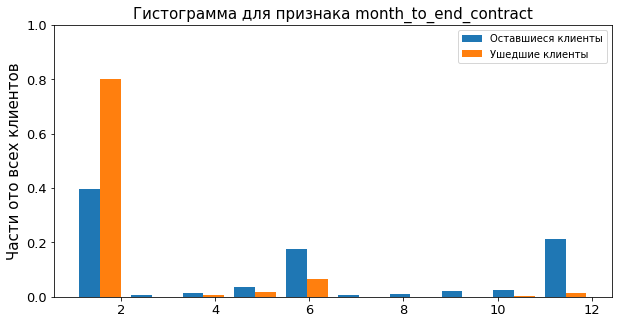

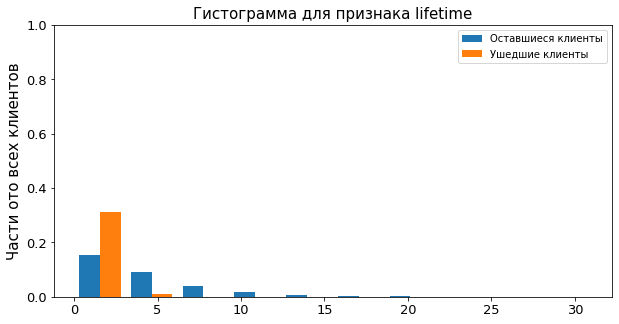

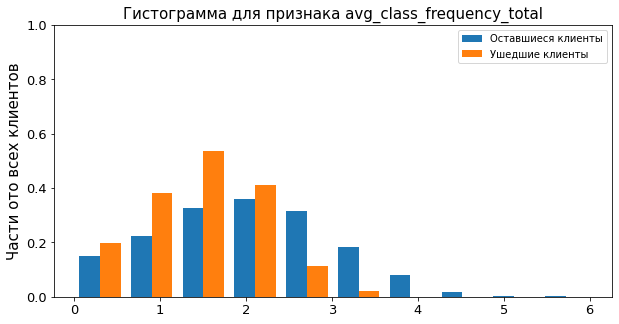

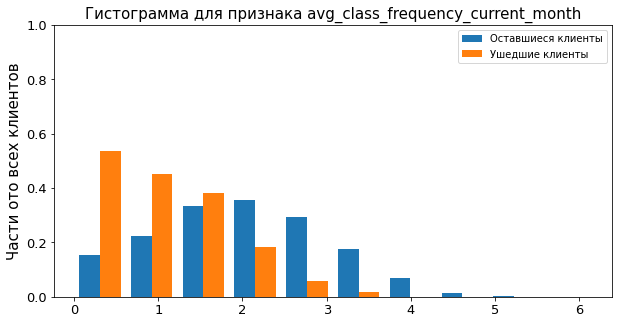

In [9]:
#Построим гистограммы для числовых значений.
df_not_bool = df[['contract_period', 'month_to_end_contract', 'lifetime',
                  'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']]
hist_func(df_not_bool, 0, 1, 'Части ото всех клиентов')

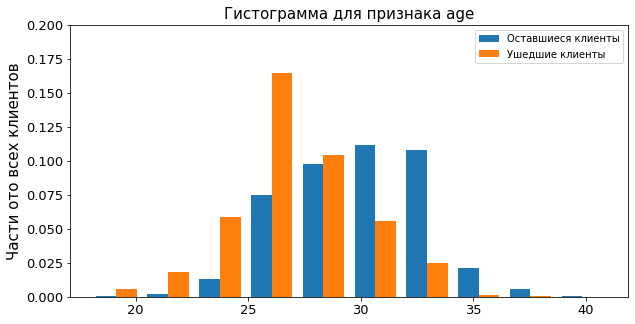

In [10]:
#Построим гистограммы для числовых значений возраста.
df_not_bool2 = df[['age', 'churn']]
hist_func(df_not_bool2, 0, 0.2, 'Части ото всех клиентов')

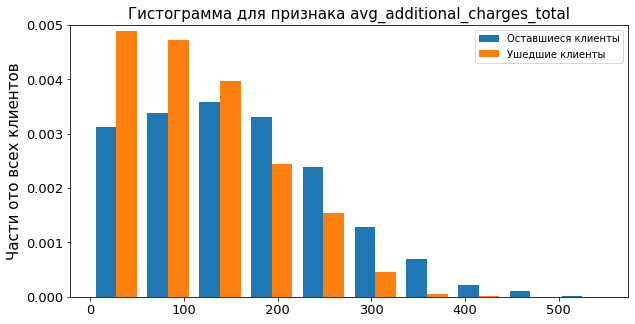

In [11]:
#Построим гистограммы для числовых значений покупок.
df_not_bool2 = df[['avg_additional_charges_total', 'churn']]
hist_func(df_not_bool2, 0, 0.005, 'Части ото всех клиентов')

Гистограммы наглядно иллюстрируют описанные нами выше закономерности. Посмотрим на матрицу корреляций.

Гистограммы наглядно иллюстрируют описанные нами выше закономерности. Посмотрим на распределение признаков.

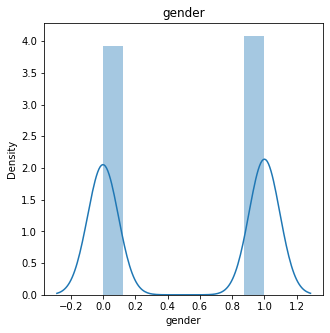

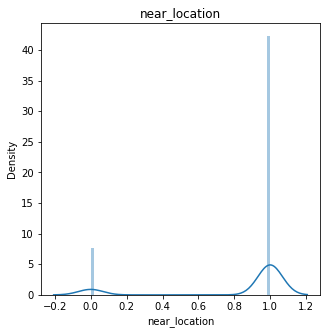

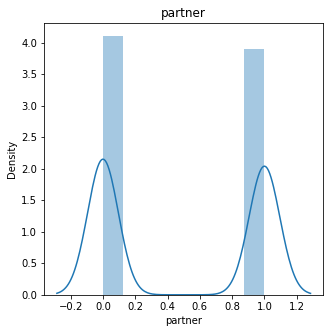

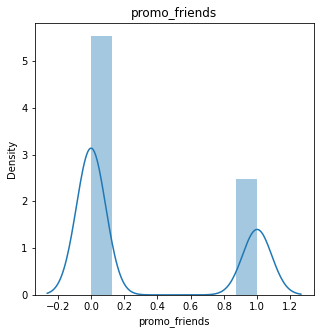

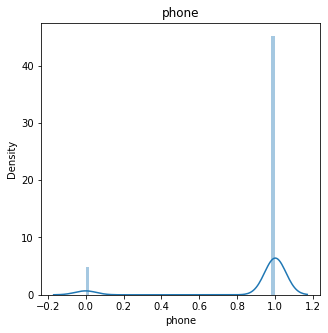

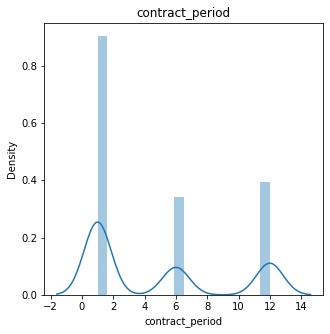

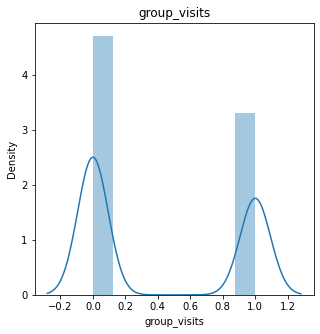

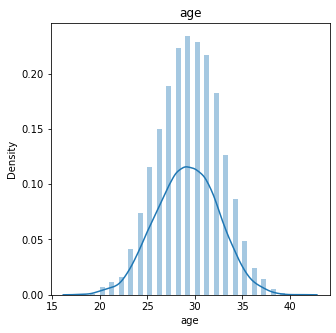

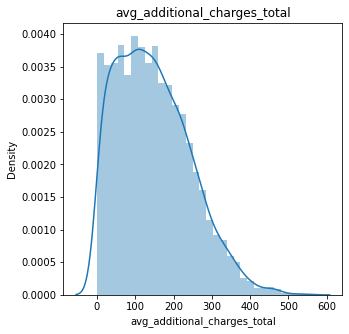

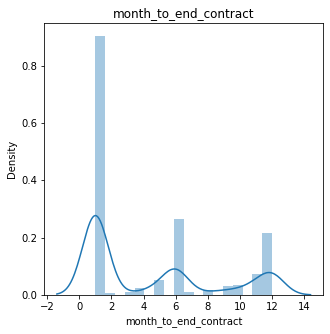

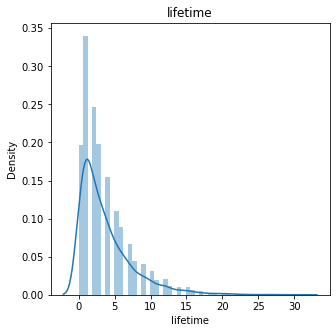

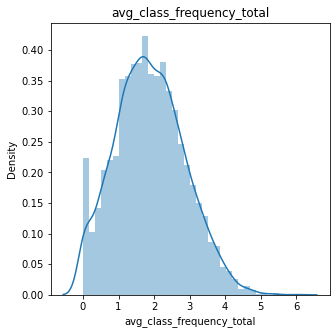

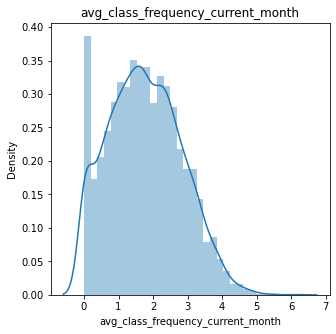

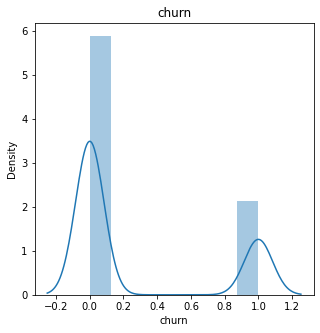

In [12]:
for column in df.columns:
    plt.figure(figsize=(5, 5))
    df.groupby('churn')[column]
    sns.distplot(df[column])
    plt.title(column)
    plt.show()

По этим графикам можем видеть, что возраст и количество посещений в неделю за все время и за месяц распределены нормально,а сумма покупок и время пользований услугами ФЦ скошены в сторону нулевых значений.

### Визуализация матрицы корреляций

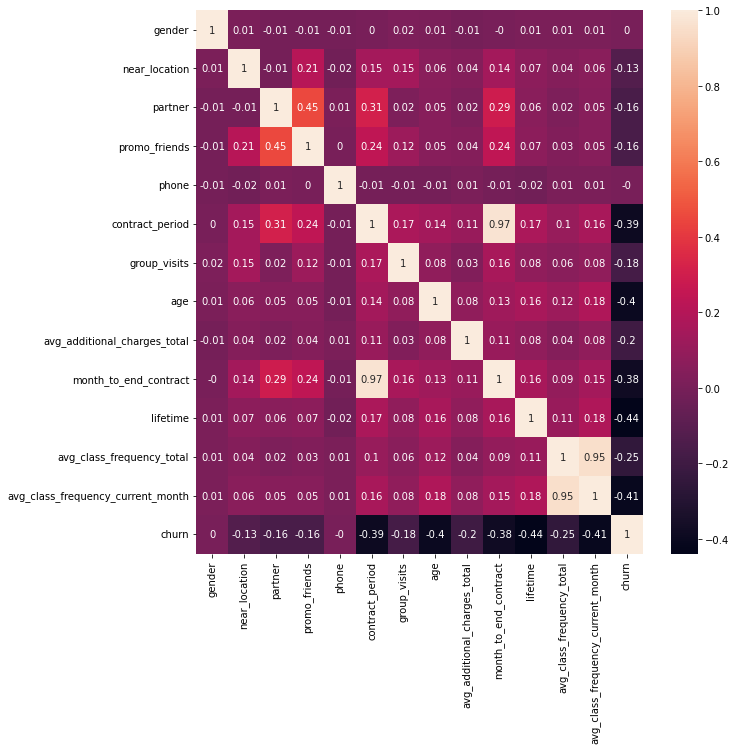

In [13]:
#вычисляем матрицу корреляций
cm = round(df.corr(), 2)
#fig, ax = plt.subplots()

#нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
# корректировка "рваных" полей heatmap в последней версии библиотеки
#ax.set_ylim(7, 0)
plt.show()

По матрице корреляций можем увидеть, что по шкале Чеддока у нас имеется умеренная обратная корреляция между склонностью к оттоку и сроком действия/до конца действия договора, количеством посещений занятий в последний месяц, сроком пользования услугами ФЦ, возрастом.
В дополнение к этому, количество посещений в неделю за все время и за последний месяц сильно коррелируют между собой. Так же, как и срок действия договора и время до его окончания, что вполне логично. 

### Вывод

<div style="border:solid green 2px; padding: 20px">
Проведя предварительный исследовательский анализ данных (EDA), можно сделать следующие выводы:  
    
- по средним значениям **видна большая лояльность тех клиентов, кто не ушел**, и меньшая тех, кто уже ушел, а именно:
- **в 5 раз больше срок пользования услугами ФЦ** (4.7 месяцев против 1)
- **в 3 раза выше срок договора** (5.7 месяцев против 1.7) и **срок до окончания действия договора** (5,3 месяца против 1.6) 
- **в два раза больше посещений за последний месяц** (2 против 1) и **в полтора раза за весь период** (2 против 1.5)
- **в два и полтора раза соответственно выше факт скидочных программ за приведенного друга и за компанию-партнера** (35% и 53% против 18% и 36% соответственно)
- **в полтора раза больше средние покупки в фитнес-центре** (159 против 115) **и количество клиентов, посещающих групповые занятия** (46% против 27%) 
- возраст и количество посещений в неделю за все время и за месяц распределены нормально, а сумма покупок и время пользований услугами ФЦ скошены в сторону нулевых значений
- по шкале Чеддока у нас имеется **умеренная обратная корреляция между склонностью к оттоку и сроком действия/до конца действия договора, количеством посещений занятий в последний месяц, сроком пользования услугами ФЦ, возрастом**
- **количество посещений в неделю за все время и за последний месяц сильно коррелируют между собой**. Так же, как и **срок действия договора и время до его окончания**, что вполне логично

## Построение модели прогнозирования оттока клиентов

### Выбор лучшей модели

В связи с тем, что нам важнее не упустить склонного к оттоку клиента, чем обозначить таковым лояльного, при выборе лучшей модели приоритет следует отдать метрике *Recall*.

В связи с тем, что в наших данных нет временной структуры и наши наблюдения не складываются в последовательный временной ряд,  используем метод случайного разбиения на обучающую и валидационную выборку.

In [14]:
#Разделим наши данные на признаки (матрица X) и целевую переменную (y).
X = df.drop(columns=['churn'])
y = df.churn

#Разделяем модель на обучающую и валидационную выборку.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#Проверяем корректность разбиения на выборки.
sample = [X_train, X_test, y_train, y_test]
for i in sample:
    print(i.shape)

(3200, 13)
(800, 13)
(3200,)
(800,)


In [15]:
#Стандартизируем данные.
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

Для прогнозирования обучим модели логистической регрессии, случайного леса, дерева принятия решений и градиентного бустинга на train-выборке, стандартизация для них необязательна. Затем сделаем предсказания всеми моделями на валидационной выборке и посмотрим на метрики каждой.

In [16]:
#Зададим список моделей
models = [LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier]

#Напишем функцию, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train_st, y_train, X_test_st, y_test):
    model = m(random_state=0)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:, 1]
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} F1:{:.2f} ROC_AUC:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            roc_auc_score(y_test, probabilities)
        )
    )

In [17]:
#Используем цикл, который выводит метрики по списку моделей
for i in models:
    print(i())
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression()
Accuracy:0.94 Precision:0.90 Recall:0.85 F1:0.87 ROC_AUC:0.98
RandomForestClassifier()
Accuracy:0.92 Precision:0.88 Recall:0.83 F1:0.85 ROC_AUC:0.97
DecisionTreeClassifier()
Accuracy:0.89 Precision:0.78 Recall:0.80 F1:0.79 ROC_AUC:0.86
GradientBoostingClassifier()
Accuracy:0.94 Precision:0.92 Recall:0.84 F1:0.88 ROC_AUC:0.98


По метрикам можно увидеть, что все модели показали себя примерно одинаково хорошо, но градиентный бустинг все-таки лучше всех остальных.

### Выбор лучшей модели с учетом сниженного порога вероятности

В связи с тем, что нам важнее не упустить склонного к оттоку клиента, чем обозначить таковым лояльного, попробуем посмотреть на наши модели со сниженным порогом вероятности отнесения к этой склонности и посмотрим на новые метрики.

In [18]:
#Зададим список моделей
models = [LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier]

#Напишем функцию, которая принимает на вход модель и данные и выводит метрики
def make_prediction2(m, X_train_st, y_train, X_test_st, y_test):
    model = m(random_state=0)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:, 1]
    #Зададим порог
    threshold = 0.35
    #На основании вероятностей и соотношения классов рассчитаем predict
    custom_predictions = [0 if i < threshold else 1 for i in probabilities]
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} F1:{:.2f} ROC_AUC:{:.2f}'.format(
            accuracy_score(y_test, custom_predictions),
            precision_score(y_test, custom_predictions),
            recall_score(y_test, custom_predictions),
            f1_score(y_test, custom_predictions),
            roc_auc_score(y_test, probabilities)
        )
    )

In [19]:
#Используем цикл, который выводит метрики по списку моделей
for i in models:
    print(i())
    make_prediction2(i, X_train, y_train, X_test, y_test)

LogisticRegression()
Accuracy:0.92 Precision:0.82 Recall:0.87 F1:0.85 ROC_AUC:0.97
RandomForestClassifier()
Accuracy:0.92 Precision:0.82 Recall:0.91 F1:0.86 ROC_AUC:0.97
DecisionTreeClassifier()
Accuracy:0.89 Precision:0.78 Recall:0.80 F1:0.79 ROC_AUC:0.86
GradientBoostingClassifier()
Accuracy:0.94 Precision:0.88 Recall:0.89 F1:0.88 ROC_AUC:0.98


Видим, что при незначительном ухудшении метрики *Precision* улучшилась интересующая нас метрика *Recall*. При этом, все еще лучшей остается градиентный бустинг.

### Вывод

<div style="border:solid green 2px; padding: 20px">

Построив модели логистической регрессии, случайного леса, дерева принятия решений и градиентного бустинга прогнозирования оттока клиентов, по метрикам *Accuracy*, *Precision*, *Recall*, *F1*, *ROC_AUC* мы получили примерно одинаковые результаты, однако **градиентный бустинг показал себя все-таки лучше всех** остальных.  
В связи с тем, что нам важнее не упустить склонного к оттоку клиента, чем обозначить таковым лояльного, мы запустили наши модели **со сниженным порогом вероятности** отнесения к этой склонности и получили при незначительном ухудшении метрики *Precision* **улучшение интересующей нас метрики *Recall***. При этом, все еще лучшей остается градиентный бустинг.

## Кластеризация клиентов

### Определение количества кластеров по дендрограмме

В связи с тем, что для кластеризации совершенно необходима стандартизация, стандартизируем наши выборки.

In [20]:
#Cтандартизируем данные, исключив коррелирующие и ненужные данные.
sc = StandardScaler()
x_sc = sc.fit_transform(df.drop(columns=['churn', 'gender', 'contract_period', 'avg_class_frequency_total']))

#Передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage().
linked = linkage(x_sc, method = 'ward') 

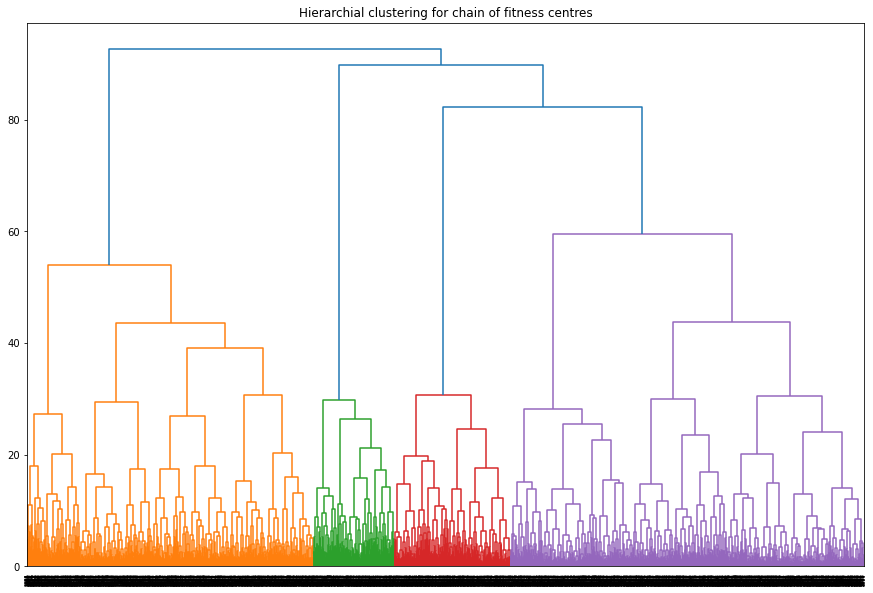

In [21]:
#Визуализируем как дендрограмму сохраненную в переменной linked таблицу «связок» между объектами 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for chain of fitness centres')
plt.show() 

Видно, что по дендрограмме можно разбить всех пользователей на 5 кластеров.
При этом, 4-й кластер получается очень большой и "размазанный" по признакам, поэтому разобьем клиентов на 5 кластеров.
По полученной информации обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

### Модель кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов

In [22]:
#Задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
#Прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

In [23]:
# сохраняем метки кластера в поле нашего датасета
df['cluster_clients'] = labels

# выводим статистику по средним значениям наших признаков по кластеру и количество клиентов в них
display(df.groupby(['cluster_clients'])['churn'].count().reset_index())
df.groupby(['cluster_clients']).mean().T

,cluster_clients,churn
0,0,771
1,1,996
2,2,971
3,3,876
4,4,386


cluster_clients,0,1,2,3,4
gender,0.523995,0.497992,0.484037,0.535388,0.523316
near_location,0.648508,0.982932,0.780639,0.925799,0.862694
partner,0.987030,0.904618,0.014418,0.101598,0.471503
promo_friends,0.032425,1.000000,0.065911,0.035388,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,5.160830,6.900602,1.887745,4.789954,4.777202
group_visits,0.278859,0.519076,0.248198,0.583333,0.427461
age,29.062257,29.491968,27.418126,30.849315,29.297927
avg_additional_charges_total,142.488891,151.613595,119.405866,177.284683,144.208179
month_to_end_contract,4.739300,6.318273,1.790937,4.430365,4.466321


По кластерам просматриваются явные закономерности - у кластера клиентов, склонных к оттоку, все показатели самые низкие. В частности, у него самый низкий показатель средних посещений за последний месяц и за все время, покупок товаров и услуг, срока пользования услугами и срока до окончания их действия, а также процент клиентов, посещающих групповые занятия и имеющих акционные предложения как сотрудник компании, а также даже самый низкий средний возраст.

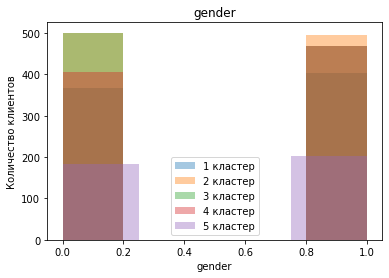

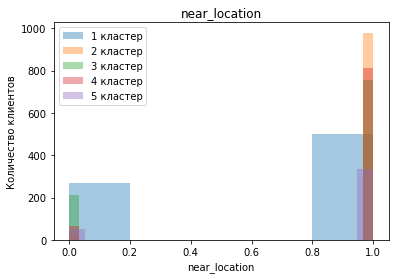

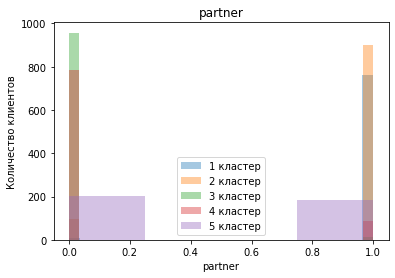

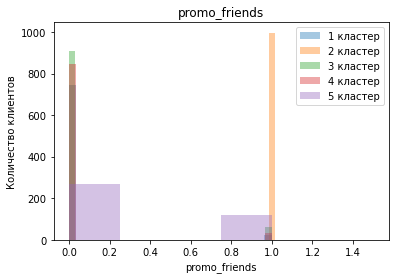

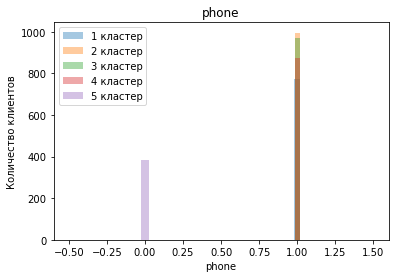

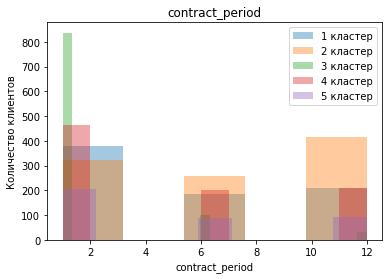

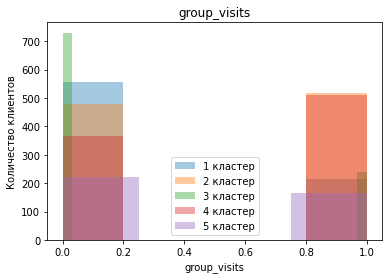

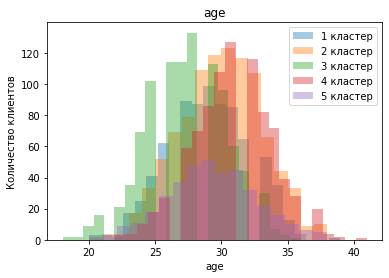

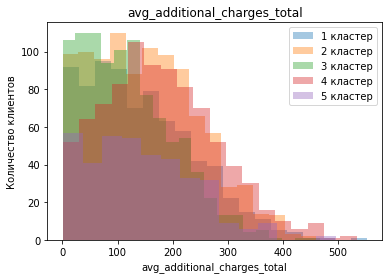

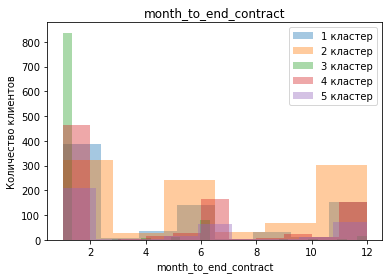

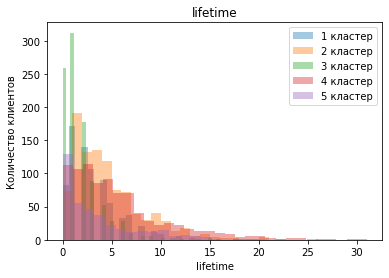

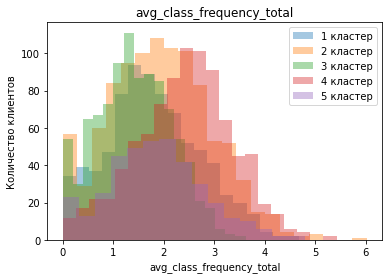

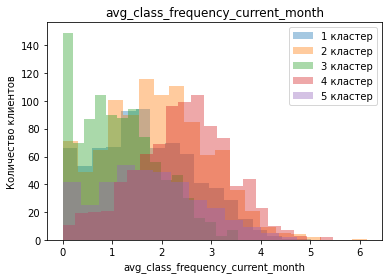

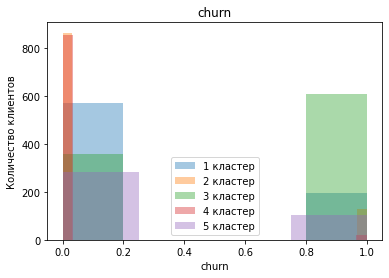

In [24]:
#Построим дистплоты для визуального отображения признаков кластеров.
zero_cluster_clients = df.query('cluster_clients == 0') 
one_cluster_clients = df.query('cluster_clients == 1') 
two_cluster_clients = df.query('cluster_clients == 2') 
three_cluster_clients = df.query('cluster_clients == 3') 
four_cluster_clients = df.query('cluster_clients == 4') 
fig, ax = plt.subplots() 
for column in df.drop('cluster_clients', axis = 1).columns: 
    plt.title(column) 
    plt.xlabel(column) 
    plt.ylabel('Количество клиентов') 
    sns.distplot(zero_cluster_clients[column], label='1 кластер', kde=False) 
    sns.distplot(one_cluster_clients[column], label='2 кластер', kde=False) 
    sns.distplot(two_cluster_clients[column], label='3 кластер', kde=False) 
    sns.distplot(three_cluster_clients[column], label='4 кластер', kde=False) 
    sns.distplot(four_cluster_clients[column], label='5 кластер', kde=False) 
    plt.legend() 
    plt.show()

Визуализация подтвердила высказанные выше закономерности. Если в остальных кластерах имеется равномерное распределение по количеству занятий за весь период и последний месяц, то в 3 кластере эти показатели смещены к нулю. По срокам действия договора этот кластер так же выделяется на фоне остальных своей близостью к нулю. И как итоге - у него наибольшие значения по оттоку.  

### Вывод

<div style="border:solid green 2px; padding: 20px">

Построив дендрограмму, разбили всех пользователей на 5 кластеров.   
По кластерам просматриваются явные закономерности - **у кластера клиентов, склонных к оттоку, все показатели самые низкие.** В частности, у него самый низкий показатель средних посещений за последний месяц и за все время, покупок товаров и услуг, срока пользования услугами и срока до окончания их действия, а также процент клиентов, посещающих групповые занятия и имеющих акционные предложения как сотрудник компании, а также даже самый низкий средний возраст.  
Визуализация подтвердила высказанные выше закономерности. Если **в остальных кластерах имеется равномерное распределение** по количеству занятий за весь период и последний месяц, то **в 3 кластере эти показатели смещены к нулю.** По срокам действия договора этот кластер так же выделяется на фоне остальных своей близостью к нулю. **И как итоге - у него наибольшие значения по оттоку.**

## Общий вывод

<div style="border:solid green 2px; padding: 20px">

Проведя исследование, можно сделать следующие выводы:
- ДФ в идеальном состоянии - дубликаты и пропуска отсутствуют, типы данных верные. Учитывая квартили и логически анализируя жизненный опыт, можно сказать, что аномальных значений в ДФ не наблюдается, все они выглядят правдоподобно и естественно. Для удобства заменены только названия столбцов.
    
- если сравнить средние значения с медианами с учетом стандартного отклонения, можно увидеть, что клиенты по полу, партнерской программе, факту посещения групповых программ, возрасту и количеству посещений в неделю за все время распределены равномерно, по локации большая часть живет рядом с ФЦ, не пользовалась услугой "приведи друга", предоставила контактный номер, оформила краткосрочный договор на услуги (и соответственно с небольшим сроком до окончания его действия), суммы покупок доп.услуг и количество посещений в неделю последний месяцскошены влево к небольшим значениям.
 
    
- по средним значениям **видна большая лояльность тех клиентов, кто не ушел**, и меньшая тех, кто уже ушел, а именно:
 - **в 5 раз больше срок пользования услугами ФЦ** (4.7 месяцев против 1)
 - **в 3 раза выше срок договора** (5.7 месяцев против 1.7) и **срок до окончания действия договора** (5,3 месяца против 1.6) 
 - **в два раза больше посещений за последний месяц** (2 против 1) и **в полтора раза за весь период** (2 против 1.5)
 - **в два и полтора раза соответственно выше факт скидочных программ за приведенного друга и за компанию-партнера** (35% и 53% против 18% и 36% соответственно)
 - **в полтора раза больше средние покупки в фитнес-центре** (159 против 115) **и количество клиентов, посещающих групповые занятия** (46% против 27%) 
 - возраст и количество посещений в неделю за все время и за месяц распределены нормально, а сумма покупок и время пользований услугами ФЦ скошены в сторону нулевых значений
- по шкале Чеддока у нас имеется **умеренная обратная корреляция между склонностью к оттоку и сроком действия/до конца действия договора, количеством посещений занятий в последний месяц, сроком пользования услугами ФЦ, возрастом**
 - **количество посещений в неделю за все время и за последний месяц сильно коррелируют между собой**. Так же, как и **срок действия договора и время до его окончания**, что вполне логично
    
- построив модели логистической регрессии, случайного леса, дерева принятия решений и градиентного бустинга прогнозирования оттока клиентов, по метрикам *Accuracy*, *Precision*, *Recall*, *F1*, *ROC_AUC* мы получили примерно одинаковые результаты, однако **градиентный бустинг показал себя все-таки лучше всех** остальных.  
- в связи с тем, что нам важнее не упустить склонного к оттоку клиента, чем обозначить таковым лояльного, мы запустили наши модели **со сниженным порогом вероятности** отнесения к этой склонности и получили при незначительном ухудшении метрики *Precision* **улучшение интересующей нас метрики *Recall***. При этом, все еще лучшей остается градиентный бустинг.   

- построив дендрограмму, разбили всех пользователей на 5 кластеров   
- по полученной информации обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов.  
- по кластерам просматриваются явные закономерности - **у кластера клиентов, склонных к оттоку, все показатели самые низкие.** В частности, у него самый низкий показатель средних посещений за последний месяц и за все время, покупок товаров и услуг, срока пользования услугами и срока до окончания их действия, а также процент клиентов, посещающих групповые занятия и имеющих акционные предложения как сотрудник компании, а также даже самый низкий средний возраст.  
- визуализация подтвердила высказанные выше закономерности. **Если в остальных кластерах имеется равномерное распределение по количеству занятий за весь период и последний месяц, то в 3 кластере эти показатели смещены к нулю.** По срокам действия договора этот кластер так же выделяется на фоне остальных своей близостью к нулю. **И как итоге - у него наибольшие значения по оттоку.**

**Рекомендации по удержанию клиентов, склонных к окончанию использования услуг фитнес-центра:**     

- предоставлять скидки на продление абонемента и пользования доп.услугами и товарами ФЦ
- предлагать участвовать в групповых программах 
- предлагать продлевать договор на более длительный срок, предоставляя дополнительные скидки за это
- предоставлять несколько бесплатных вводных программ с тренером для поддержания интереса к занятиям**